In [1]:
! pip install ta

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# For prepare data
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

import ta
from ta import add_all_ta_features
from ta.momentum import RSIIndicator, StochasticOscillator, WilliamsRIndicator
from ta.volatility import BollingerBands, AverageTrueRange
from ta.trend import MACD, ADXIndicator

from tqdm import tqdm

# For modeling
import math
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import torch
import torch.nn as nn
from torch import optim
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn.functional as F
# from pytorch_optimizer import SAM

# Prepare data

In [3]:
# 1. Hàm load data
def load_data(file_path):
    df = pd.read_csv(file_path)
    # Xử lý datetime
    # df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
    # df = df.sort_values('Datetime').drop(['Date', 'Time'], axis=1)
    df['Datetime'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Datetime').drop(['Date'], axis=1)
    return df

train_df = load_data("data/xauusd/1m/dynamic_labeled_train.csv")
val_df = load_data("data/xauusd/1m/dynamic_labeled_dev.csv")
test_df = load_data("data/xauusd/1m/dynamic_labeled_test.csv")

# train_df = train_df.loc[train_df['Datetime'].dt.year.isin(range(2018, 2021))]

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3446549 entries, 0 to 3446548
Data columns (total 7 columns):
 #   Column    Dtype         
---  ------    -----         
 0   Open      float64       
 1   High      float64       
 2   Low       float64       
 3   Close     float64       
 4   Volume    int64         
 5   Label     object        
 6   Datetime  datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 184.1+ MB


In [4]:
label_mapping = {
    'BUY': 0,
    'SELL': 1,
    'HOLD': 2
}

def map_label(x):
    return label_mapping[x] if x in label_mapping else x

# train_df['Label'] = train_df['Label'].map(map_label)
# val_df['Label'] = val_df['Label'].map(map_label)
# test_df['Label'] = test_df['Label'].map(map_label)

In [5]:
def add_technical_indicators(df):
    """Thêm các chỉ báo kỹ thuật."""
    print("Thêm các chỉ báo kỹ thuật...")
    # Momentum
    df['RSI'] = ta.momentum.RSIIndicator(df['Close']).rsi()
    df['Momentum'] = ta.momentum.ROCIndicator(df['Close']).roc()
    df['CMO'] = ta.momentum.kama(df['Close'])
    df['Williams_%R'] = ta.momentum.WilliamsRIndicator(df['High'], df['Low'], df['Close']).williams_r()
    # Volatility
    df['ATR'] = ta.volatility.AverageTrueRange(df['High'], df['Low'], df['Close']).average_true_range()
    bb = ta.volatility.BollingerBands(df['Close'])
    df['BB_Mid'] = bb.bollinger_mavg()
    df['BB_Upper'] = bb.bollinger_hband()
    df['BB_Lower'] = bb.bollinger_lband()
    df['BB_Bandwidth'] = bb.bollinger_wband()
    keltner = ta.volatility.KeltnerChannel(df['High'], df['Low'], df['Close'])
    df['KC_High'] = keltner.keltner_channel_hband()
    df['KC_Low'] = keltner.keltner_channel_lband()
    donchian = ta.volatility.DonchianChannel(df['High'], df['Low'], df['Close'])
    df['DC_High'] = donchian.donchian_channel_hband()
    df['DC_Low'] = donchian.donchian_channel_lband()
    # Trend
    df['SMA_20'] = ta.trend.SMAIndicator(df['Close'], window=20).sma_indicator()
    df['EMA_20'] = ta.trend.EMAIndicator(df['Close'], window=20).ema_indicator()
    df['DPO'] = ta.trend.DPOIndicator(df['Close']).dpo()
    macd = ta.trend.MACD(df['Close'])
    df['MACD'] = macd.macd()
    df['MACD_Hist'] = macd.macd_diff()
    df['Mass_Index'] = ta.trend.mass_index(df['High'], df['Low'])
    # Volume
    df['AD'] = ta.volume.AccDistIndexIndicator(df['High'], df['Low'], df['Close'], df['Volume']).acc_dist_index()
    df['CMF'] = ta.volume.ChaikinMoneyFlowIndicator(df['High'], df['Low'], df['Close'], df['Volume']).chaikin_money_flow()
    df['Force_Index'] = ta.volume.ForceIndexIndicator(df['Close'], df['Volume']).force_index()
    df['MFI'] = ta.volume.MFIIndicator(df['High'], df['Low'], df['Close'], df['Volume']).money_flow_index()
    df['OBV'] = ta.volume.OnBalanceVolumeIndicator(df['Close'], df['Volume']).on_balance_volume()

    print("Hoàn thành thêm chỉ báo.")
    return df.reset_index(drop=True)

train_df = add_technical_indicators(train_df)
val_df = add_technical_indicators(val_df)
test_df = add_technical_indicators(test_df)

train_df.info()

Thêm các chỉ báo kỹ thuật...
Hoàn thành thêm chỉ báo.
Thêm các chỉ báo kỹ thuật...
Hoàn thành thêm chỉ báo.
Thêm các chỉ báo kỹ thuật...
Hoàn thành thêm chỉ báo.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3446549 entries, 0 to 3446548
Data columns (total 31 columns):
 #   Column        Dtype         
---  ------        -----         
 0   Open          float64       
 1   High          float64       
 2   Low           float64       
 3   Close         float64       
 4   Volume        int64         
 5   Label         object        
 6   Datetime      datetime64[ns]
 7   RSI           float64       
 8   Momentum      float64       
 9   CMO           float64       
 10  Williams_%R   float64       
 11  ATR           float64       
 12  BB_Mid        float64       
 13  BB_Upper      float64       
 14  BB_Lower      float64       
 15  BB_Bandwidth  float64       
 16  KC_High       float64       
 17  KC_Low        float64       
 18  DC_High       float64       
 19  DC_Low

In [6]:
def add_basic_features(df):
    """Tiền xử lý cuối: pct_change, ánh xạ nhãn, thêm đặc trưng thời gian."""
    print("Áp dụng tiền xử lý...")
    # Tính phần trăm thay đổi cho OHLC
    cols_to_pct = ['Open', 'High', 'Low', 'Close']
    existing_cols = [col for col in cols_to_pct if col in df.columns]
    if existing_cols:
        print(f"Tính phần trăm thay đổi cho: {existing_cols}")
        df[existing_cols] = df[existing_cols].pct_change().fillna(0) * 100
        df['Cum_Return'] = df['Close'].rolling(window=20).sum()
        df['Cum_Turnover'] = df['Volume'].rolling(window=20).sum()
    else:
        print("Cảnh báo: Không tìm thấy cột OHLC để tính pct_change.")

    # Thêm đặc trưng thời gian
    if 'Datetime' in df.columns:
        print("Thêm đặc trưng thời gian (hour, day_of_week, minute_of_day, index)...")
        df['Hour'] = df['Datetime'].dt.hour / 23.0 #(chuẩn hóa về [0,1]).
        df['Day_Of_Week'] = df['Datetime'].dt.dayofweek / 6.0
        df['Minute_Of_Day'] = (df['Datetime'].dt.hour * 60 + df['Datetime'].dt.minute) / 1439.0
        # df = df.drop(columns=['Datetime'], errors='ignore')
    else:
        print("Cảnh báo: Không thể tạo đặc trưng thời gian do thiếu cột 'Datetime'.")

    print("Hoàn thành tiền xử lý.")
    return df.reset_index(drop=True)

train_df = add_basic_features(train_df)
val_df = add_basic_features(val_df)
test_df = add_basic_features(test_df)
train_df.info()

Áp dụng tiền xử lý...
Tính phần trăm thay đổi cho: ['Open', 'High', 'Low', 'Close']
Thêm đặc trưng thời gian (hour, day_of_week, minute_of_day, index)...
Hoàn thành tiền xử lý.
Áp dụng tiền xử lý...
Tính phần trăm thay đổi cho: ['Open', 'High', 'Low', 'Close']
Thêm đặc trưng thời gian (hour, day_of_week, minute_of_day, index)...
Hoàn thành tiền xử lý.
Áp dụng tiền xử lý...
Tính phần trăm thay đổi cho: ['Open', 'High', 'Low', 'Close']
Thêm đặc trưng thời gian (hour, day_of_week, minute_of_day, index)...
Hoàn thành tiền xử lý.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3446549 entries, 0 to 3446548
Data columns (total 36 columns):
 #   Column         Dtype         
---  ------         -----         
 0   Open           float64       
 1   High           float64       
 2   Low            float64       
 3   Close          float64       
 4   Volume         int64         
 5   Label          object        
 6   Datetime       datetime64[ns]
 7   RSI            float64       
 8   M

In [7]:
def drop_na_cols(df, threshold=0.01):
    cnt = 0
    for col in df.columns:
        na = df[[col]].isna().sum()
        if na.values > len(df) * threshold:
            df.drop(col, axis=1, inplace=True)
            cnt += 1
    print(f'Deleted {cnt} cols')
    return df

# 6. Hàm xử lý missing values
def handle_missing_data(df, threshold=0.01):
    df = drop_na_cols(df, threshold)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    df = df.bfill().ffill()
    df = df.dropna()
    
    return df

# train_df
train_df = handle_missing_data(train_df)
val_df = handle_missing_data(val_df)
test_df = handle_missing_data(test_df)
train_df.info()

Deleted 0 cols
Deleted 0 cols
Deleted 0 cols
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3446549 entries, 0 to 3446548
Data columns (total 36 columns):
 #   Column         Dtype         
---  ------         -----         
 0   Open           float64       
 1   High           float64       
 2   Low            float64       
 3   Close          float64       
 4   Volume         int64         
 5   Label          object        
 6   Datetime       datetime64[ns]
 7   RSI            float64       
 8   Momentum       float64       
 9   CMO            float64       
 10  Williams_%R    float64       
 11  ATR            float64       
 12  BB_Mid         float64       
 13  BB_Upper       float64       
 14  BB_Lower       float64       
 15  BB_Bandwidth   float64       
 16  KC_High        float64       
 17  KC_Low         float64       
 18  DC_High        float64       
 19  DC_Low         float64       
 20  SMA_20         float64       
 21  EMA_20         float64       
 2

In [8]:
def scale_features(train_df, val_df, test_df, excepts=['Label', 'Datetime']):
    feature_columns = [col for col in train_df.columns if col not in excepts]
    
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train_df[feature_columns])
    val_scaled = scaler.transform(val_df[feature_columns])
    test_scaled = scaler.transform(test_df[feature_columns])
    
    scaled_train_df = pd.DataFrame(train_scaled, columns=feature_columns, index=train_df.index)
    scaled_val_df = pd.DataFrame(val_scaled, columns=feature_columns, index=val_df.index)
    scaled_test_df = pd.DataFrame(test_scaled, columns=feature_columns, index=test_df.index)
    
    for scaled_df, df in zip([scaled_train_df, scaled_val_df, scaled_test_df], [train_df, val_df, test_df]):
        for col in excepts:
            scaled_df[col] = df[col].values
    
    return scaled_train_df, scaled_val_df, scaled_test_df

train_df, val_df, test_df = scale_features(train_df, val_df, test_df, excepts=['Label', 'Datetime'])
train_df

,Open,High,Low,Close,Volume,RSI,Momentum,CMO,Williams_%R,ATR,...,Force_Index,MFI,OBV,Cum_Return,Cum_Turnover,Hour,Day_Of_Week,Minute_Of_Day,Label,Datetime
0,-0.000443,-0.000462,-0.000450,-0.000444,11.866324,1.431035,3.059671,0.087107,0.708607,-1.237493,...,4.403615,1.220349,-1.241473,-1.053811,23.668199,-1.504001,-1.405197,-1.577669,SELL,2011-01-03 01:00:00
1,-0.180447,-0.312442,-0.534944,0.900156,8.180285,1.431035,3.059671,0.087107,0.708607,-1.237493,...,4.403615,1.220349,-1.241122,-1.053811,23.668199,-1.352104,-1.405197,-1.425868,BUY,2011-01-03 02:00:00
2,0.796754,4.140691,-0.829033,1.440159,10.473273,1.431035,3.059671,0.087107,0.708607,-1.237493,...,4.403615,1.220349,-1.240683,-1.053811,23.668199,-1.200207,-1.405197,-1.274068,BUY,2011-01-03 03:00:00
3,1.439340,2.124653,1.764015,0.539569,12.174521,1.431035,3.059671,0.087107,0.708607,-1.237493,...,4.403615,1.220349,-1.240177,-1.053811,23.668199,-1.048310,-1.405197,-1.122267,BUY,2011-01-03 04:00:00
4,0.642063,3.851042,4.034550,7.018677,9.437730,1.431035,3.059671,0.087107,0.708607,-1.237493,...,4.403615,1.220349,-1.239777,-1.053811,23.668199,-0.896412,-1.405197,-0.970467,BUY,2011-01-03 05:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3446544,-0.616385,1.443997,-0.420441,1.925836,0.487682,-1.116948,-1.451967,2.265725,-0.679340,0.703364,...,-0.146573,-1.003846,1.952694,-0.743482,0.152036,1.230147,0.693603,1.187630,SELL,2020-12-31 19:13:00
3446545,1.924700,1.337306,2.539772,0.519377,0.056206,-0.836418,-1.377339,2.265924,-0.468369,0.700586,...,-0.070416,-1.125499,1.952731,-0.546768,0.169081,1.230147,0.693603,1.190160,BUY,2020-12-31 19:14:00
3446546,0.345899,-0.913237,-0.220322,-0.500940,-0.054745,-1.015068,-1.589346,2.265959,-0.671526,0.644096,...,-0.106187,-1.100206,1.952699,-0.730063,0.164110,1.230147,0.693603,1.192690,BUY,2020-12-31 19:15:00
3446547,-0.327514,-0.318944,-0.939956,-1.136342,0.031550,-1.384047,-1.778748,2.265654,-1.132535,0.645552,...,-0.206640,-1.468447,1.952663,-1.168195,0.166951,1.230147,0.693603,1.195220,BUY,2020-12-31 19:16:00


In [9]:
def compute_corr(df, start_dt=None, end_dt=None):
    df = df.copy()
    if start_dt and end_dt:
        start_dt = pd.to_datetime(start_dt)
        end_dt = pd.to_datetime(end_dt)
        df = df[(df['Datetime'] >= start_dt) & (df['Datetime'] <= end_dt)]
    
    buy = df.loc[df['Label'] == 'BUY']
    sell = df.loc[df['Label'] == 'SELL']

    print(f"Số lượng mẫu của BUY và SELL: {len(buy)}, {len(sell)}")

    # Bỏ cột Label nếu có
    buy_features = buy.drop(columns=['Label', 'Datetime'])
    sell_features = sell.drop(columns=['Label', 'Datetime'])

    # Tính correlation giữa trung bình của buy và sell
    correlation = buy_features.mean().corr(sell_features.mean())
    print("Correlation between mean features of BUY and SELL:", correlation)

    # Cần align số hàng nếu không bằng nhau (cắt bằng chiều ngắn nhất)
    min_len = min(len(buy_features), len(sell_features))
    buy_aligned = buy_features.iloc[:min_len].reset_index(drop=True)
    sell_aligned = sell_features.iloc[:min_len].reset_index(drop=True)

    # Tính Pearson correlation cho từng cột
    feature_corrs = buy_aligned.corrwith(sell_aligned)
    print(feature_corrs)
    
print('====================================================')
print('Train set:')
compute_corr(train_df)

print('====================================================')
print('Val set:')
compute_corr(val_df)

print('====================================================')
print('Train set:')
compute_corr(test_df)

Train set:
Số lượng mẫu của BUY và SELL: 1101094, 735153
Correlation between mean features of BUY and SELL: -0.488344783986112
Open             0.000177
High            -0.001778
Low              0.000714
Close            0.000237
Volume          -0.005228
RSI              0.000793
Momentum         0.002716
CMO              0.319952
Williams_%R      0.000371
ATR              0.040932
BB_Mid           0.319927
BB_Upper         0.320206
BB_Lower         0.319628
BB_Bandwidth     0.002998
KC_High          0.319954
KC_Low           0.319895
DC_High          0.320168
DC_Low           0.319717
SMA_20           0.319927
EMA_20           0.319939
DPO              0.001731
MACD             0.007064
MACD_Hist        0.003020
Mass_Index      -0.000244
AD               0.951870
CMF             -0.000078
Force_Index      0.036719
MFI             -0.002297
OBV              0.995299
Cum_Return       0.003296
Cum_Turnover    -0.006439
Hour             0.012677
Day_Of_Week      0.006419
Minute_Of_Day  

In [10]:
start_dt = '2018-11-20 10:00:00'
end_dt = '2018-11-20 12:00:00'

compute_corr(train_df, start_dt, end_dt)

Số lượng mẫu của BUY và SELL: 32, 41
Correlation between mean features of BUY and SELL: 0.6541855148944398
Open            -0.074214
High            -0.045411
Low             -0.137989
Close            0.075561
Volume           0.047182
RSI              0.106547
Momentum        -0.157250
CMO             -0.013165
Williams_%R      0.002186
ATR              0.037237
BB_Mid           0.018136
BB_Upper         0.088316
BB_Lower        -0.145406
BB_Bandwidth    -0.065379
KC_High          0.165269
KC_Low          -0.093647
DC_High          0.165518
DC_Low          -0.024602
SMA_20           0.018136
EMA_20           0.030241
DPO              0.072238
MACD             0.106363
MACD_Hist       -0.221451
Mass_Index       0.171506
AD              -0.205641
CMF             -0.130472
Force_Index      0.006136
MFI             -0.461657
OBV             -0.030908
Cum_Return       0.034592
Cum_Turnover    -0.479650
Hour             0.170193
Day_Of_Week           NaN
Minute_Of_Day    0.777651
dtype: fl

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

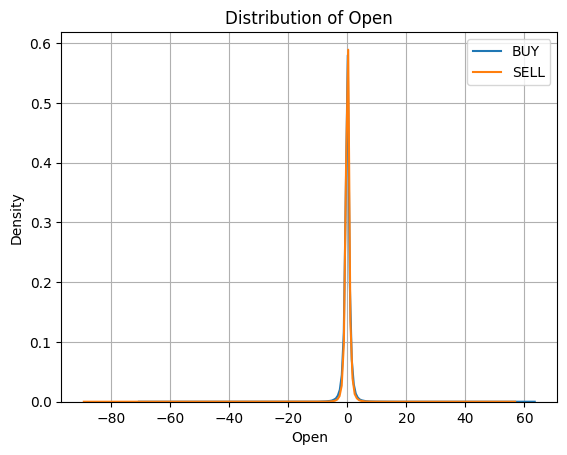

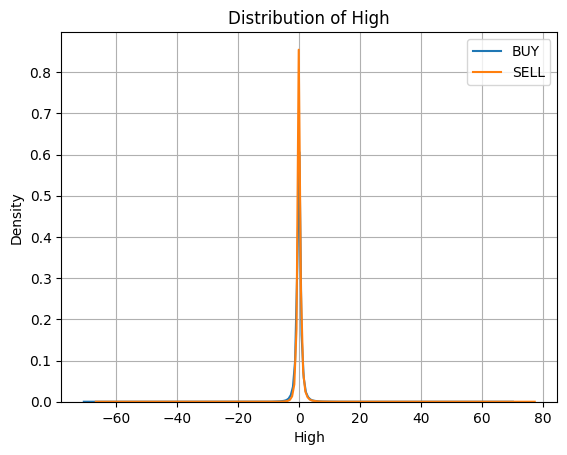

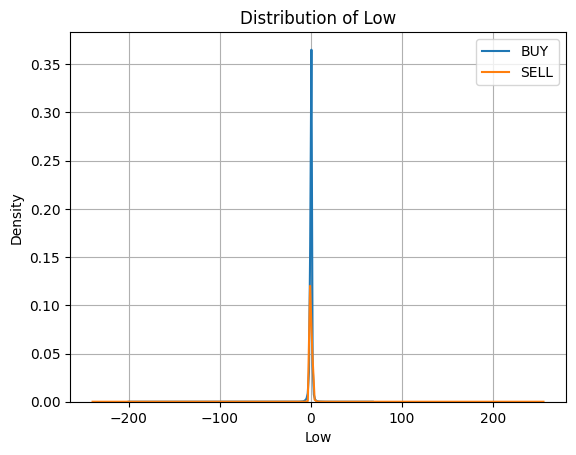

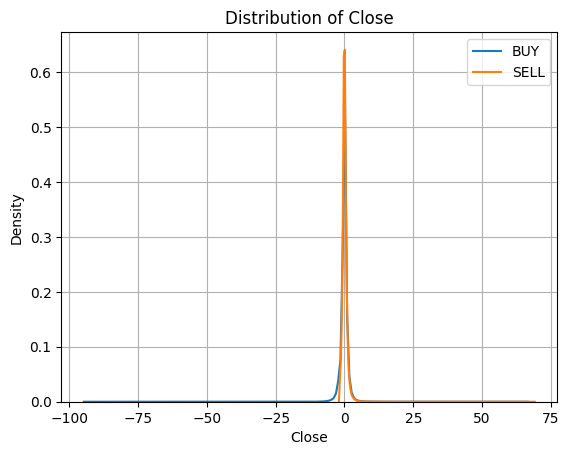

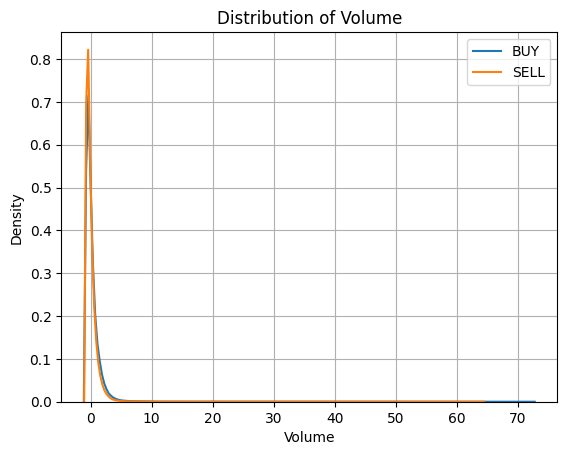

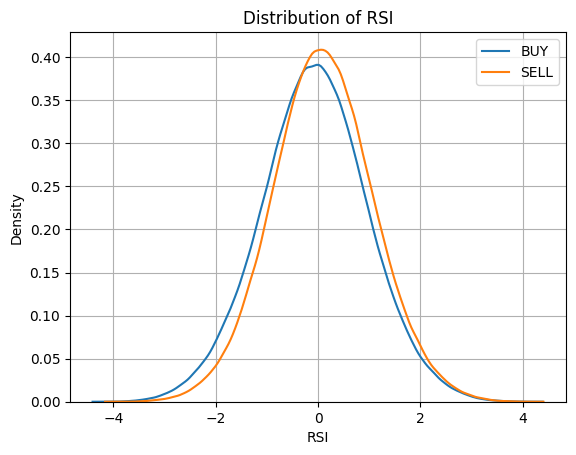

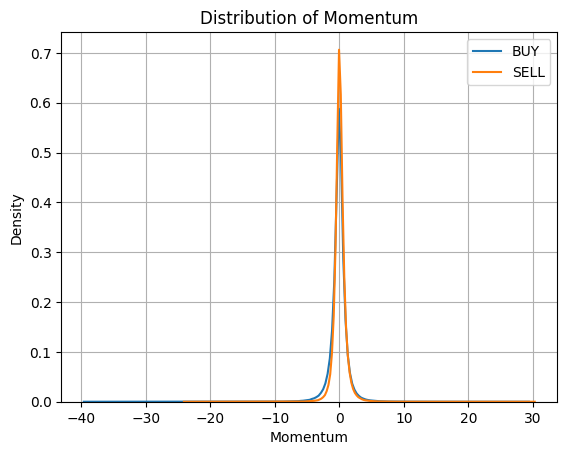

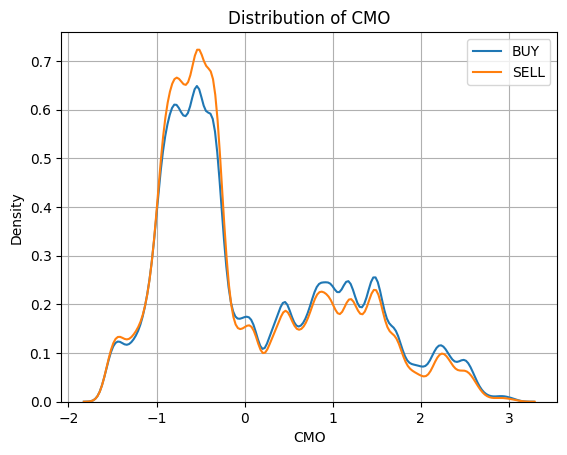

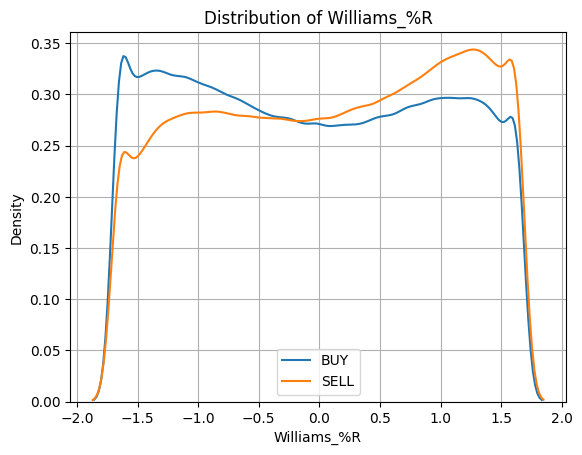

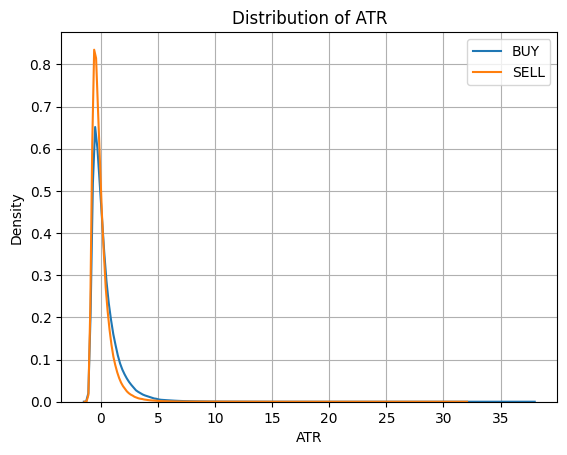

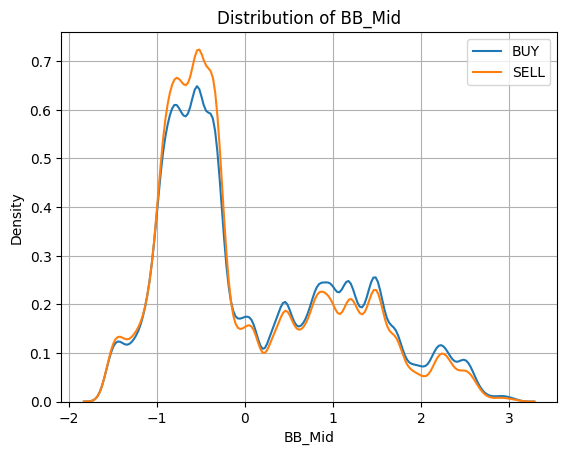

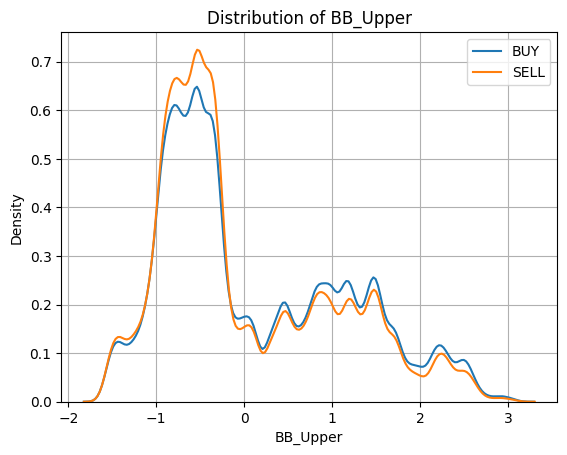

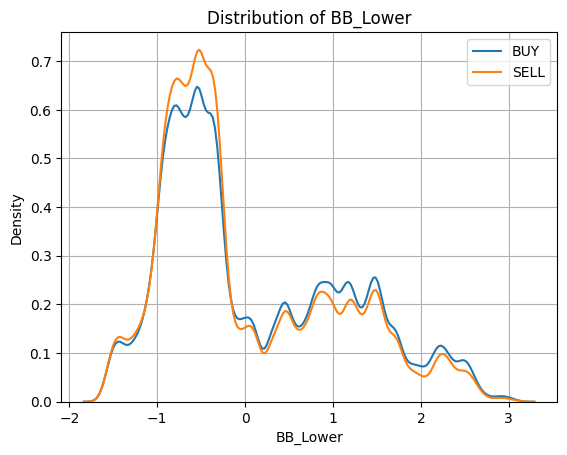

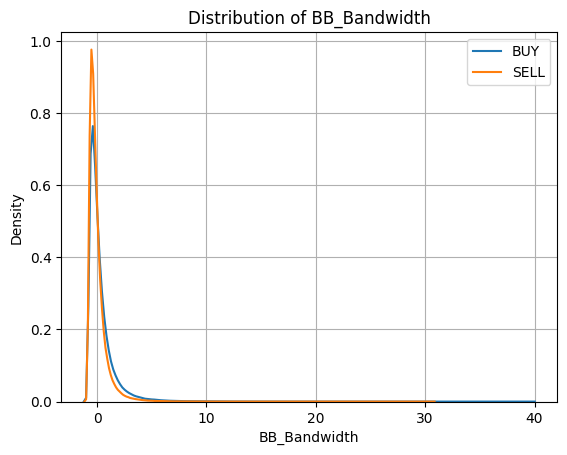

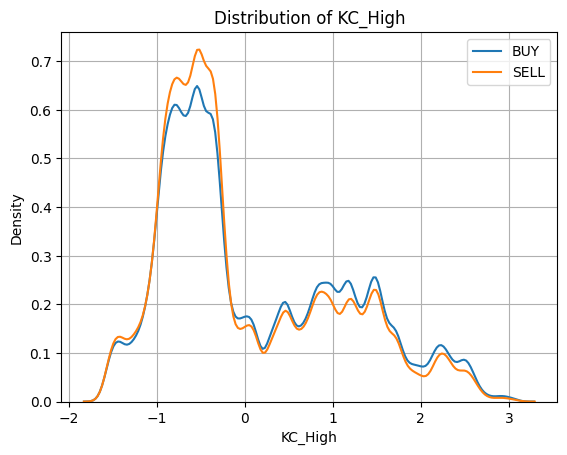

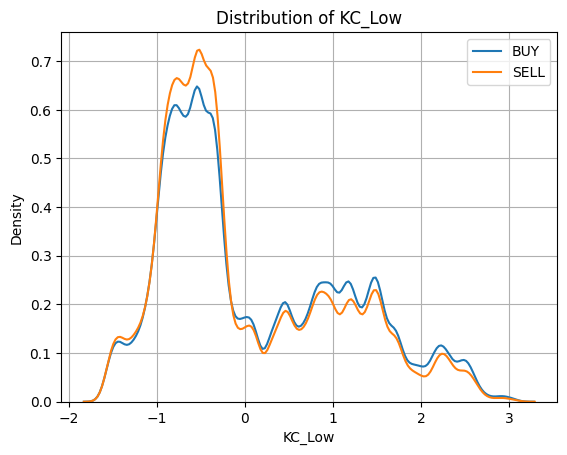

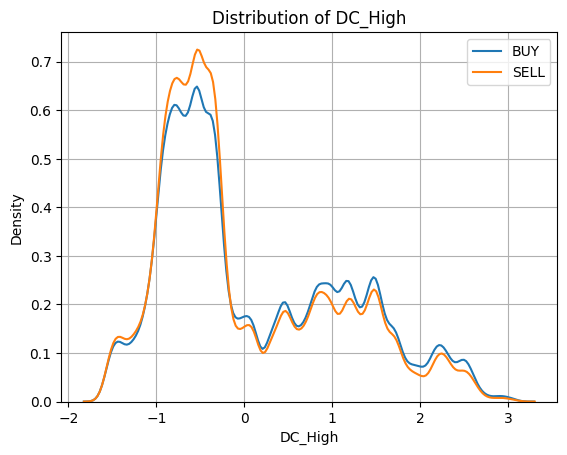

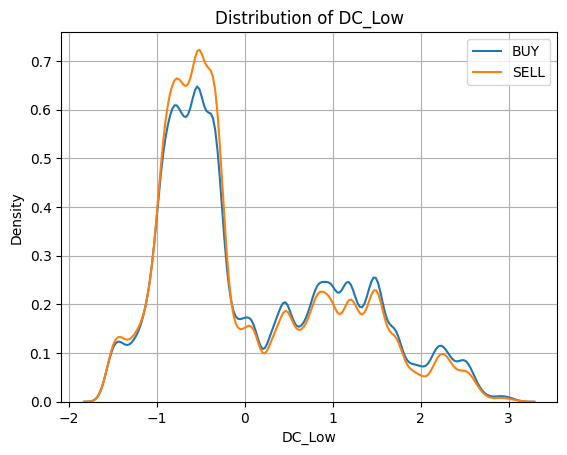

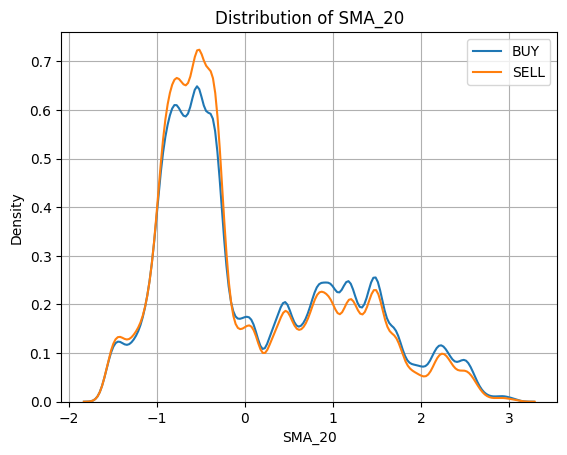

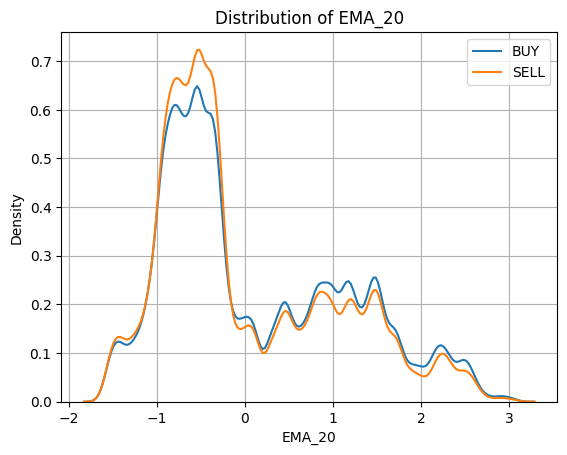

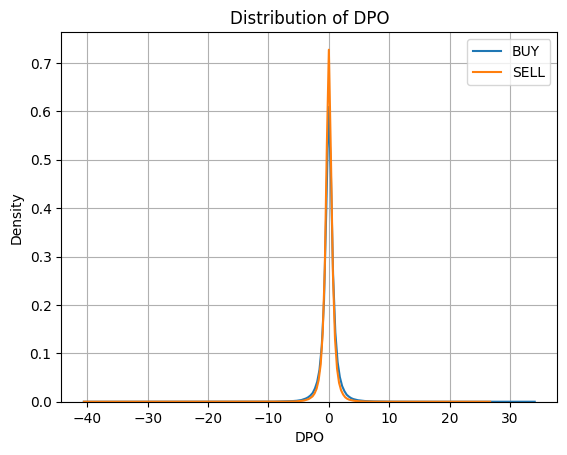

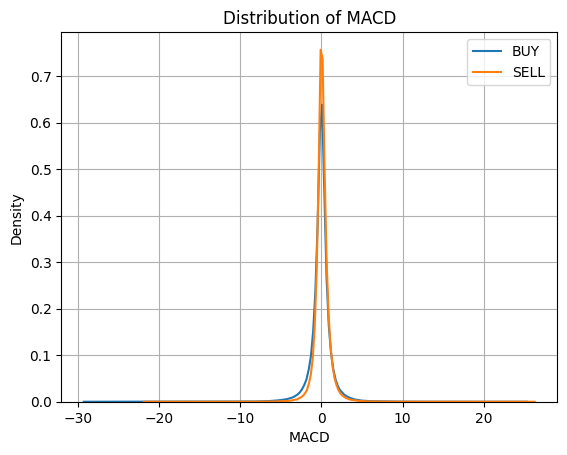

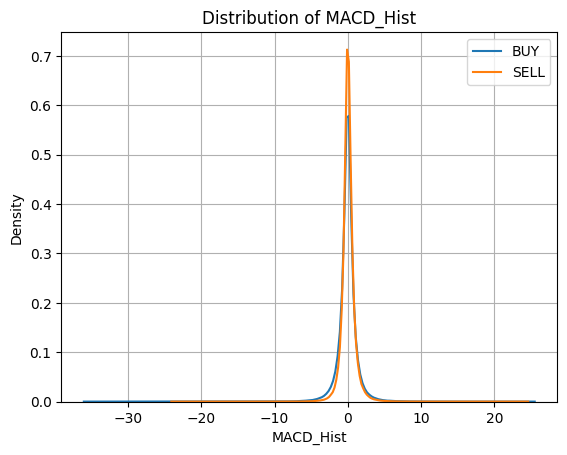

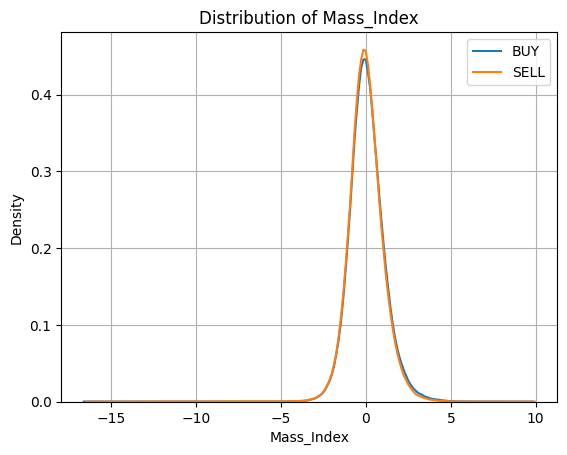

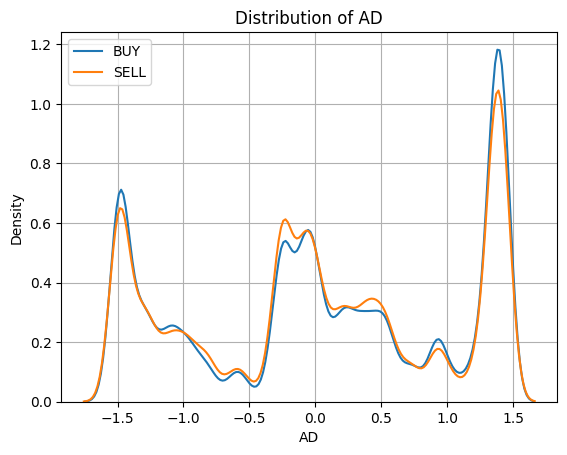

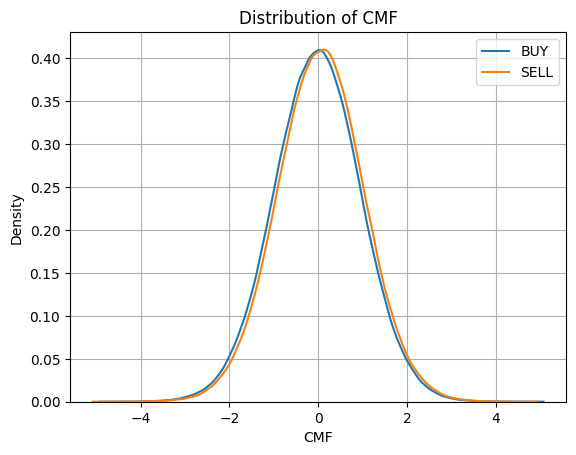

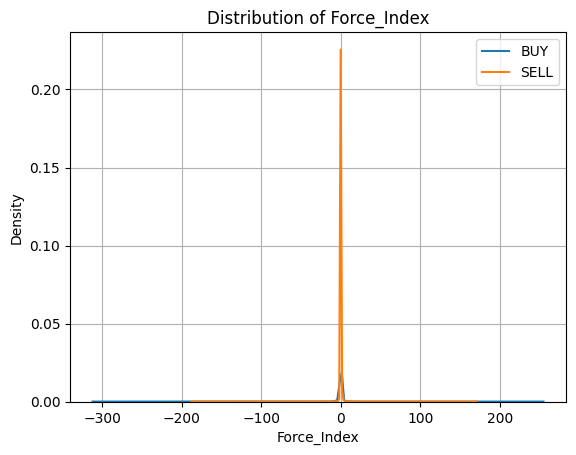

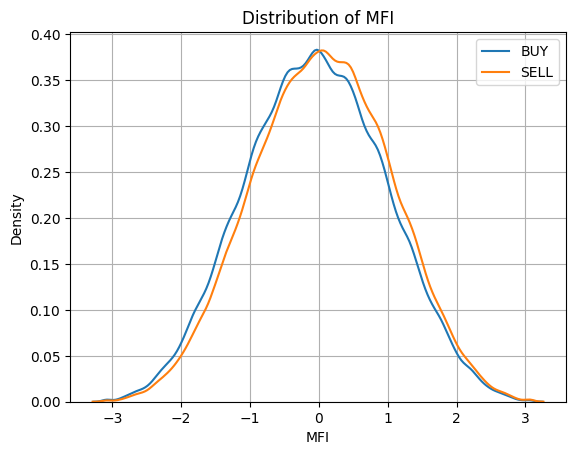

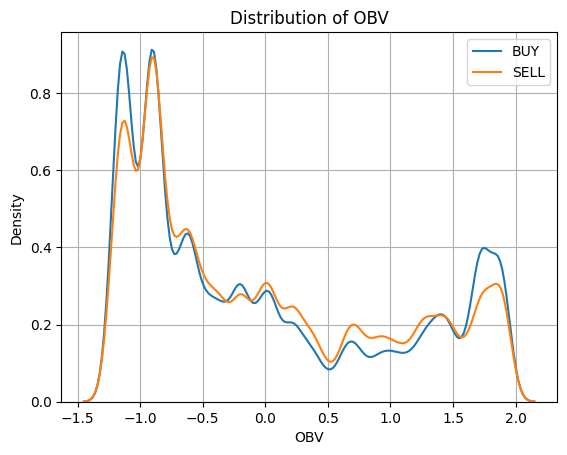

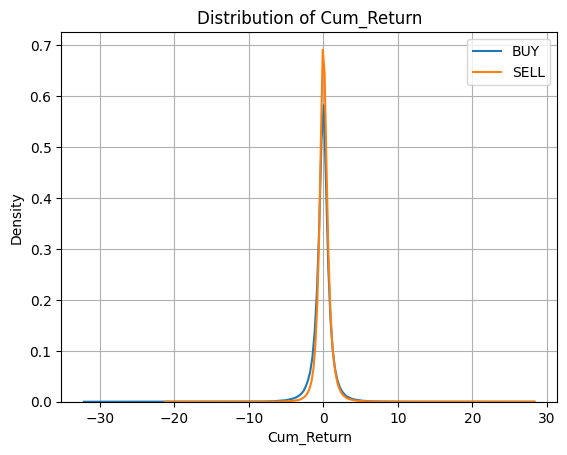

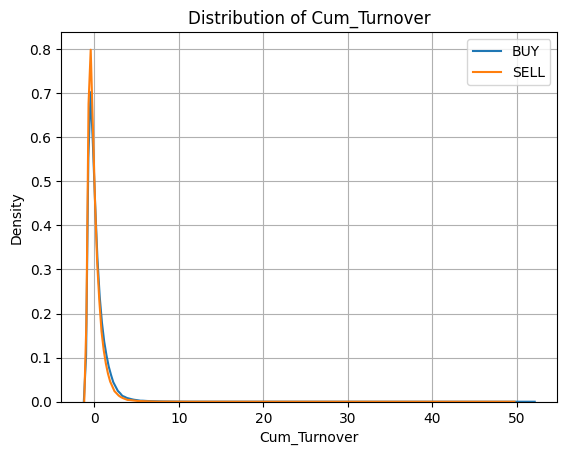

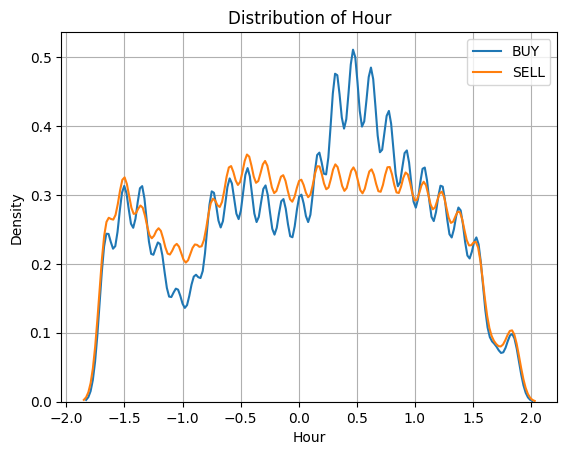

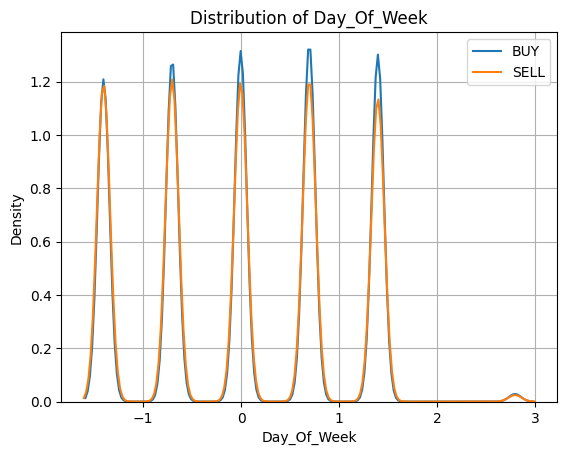

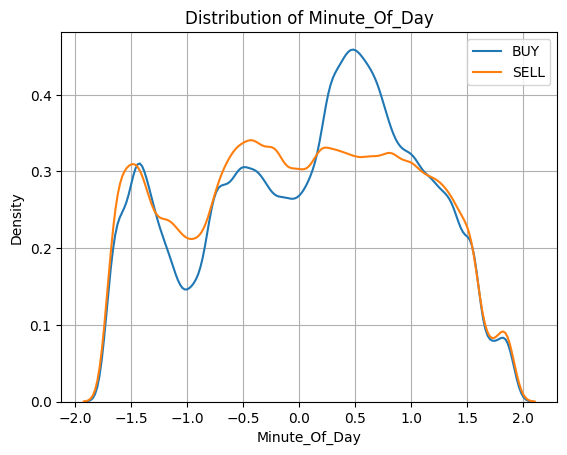

In [12]:
def visualize_kde(df, start_dt=None, end_dt=None):
    df = df.copy()
    if start_dt and end_dt:
        start_dt = pd.to_datetime(start_dt)
        end_dt = pd.to_datetime(end_dt)
        df = df[(df['Datetime'] >= start_dt) & (df['Datetime'] <= end_dt)]
        
    buy = df[df['Label'] == 'BUY']
    sell = df[df['Label'] == 'SELL']

    feature_cols = [col for col in df.columns if col not in ['Label', 'Datetime']]
        
    for col in feature_cols:
        sns.kdeplot(buy[col], label='BUY')
        sns.kdeplot(sell[col], label='SELL')
        plt.title(f'Distribution of {col}')
        plt.legend()
        plt.grid(True)
        plt.show()

visualize_kde(train_df)

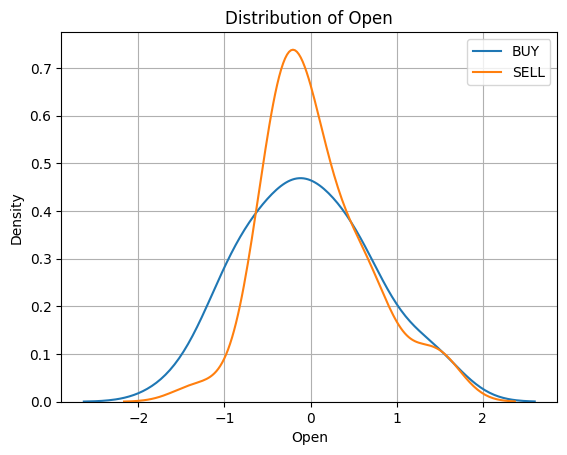

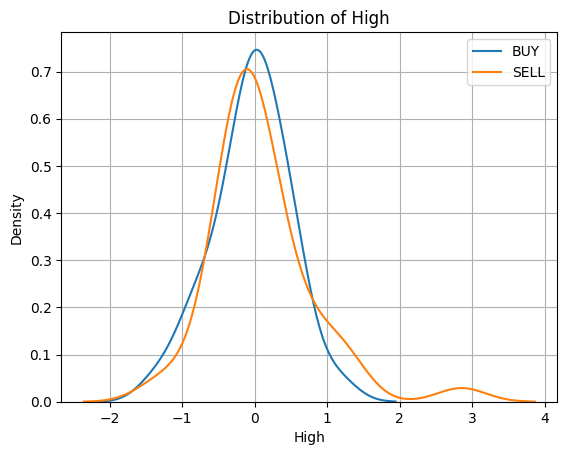

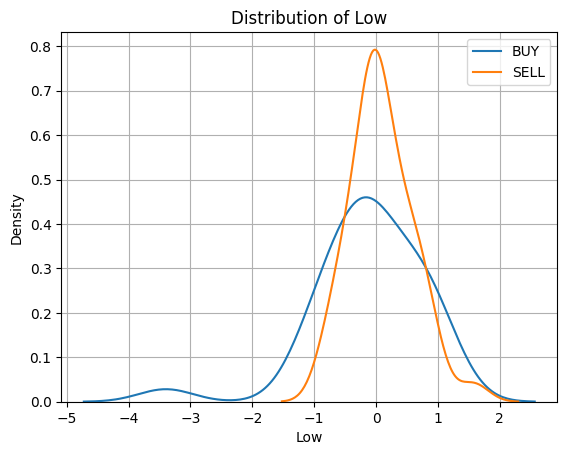

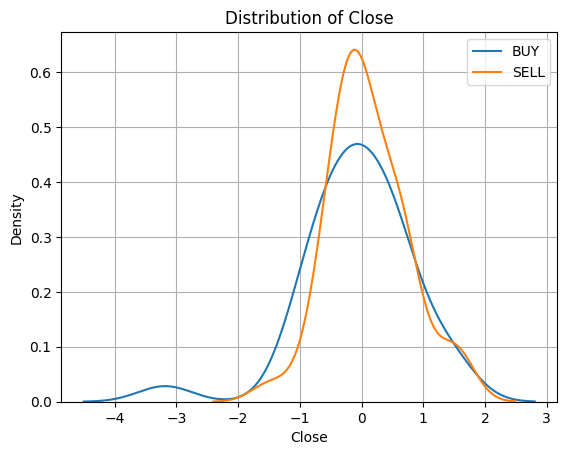

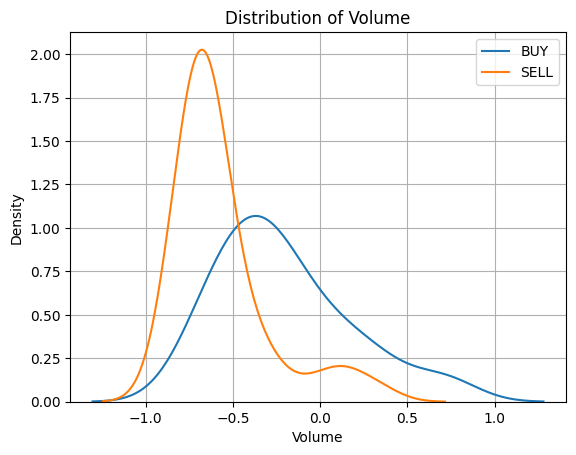

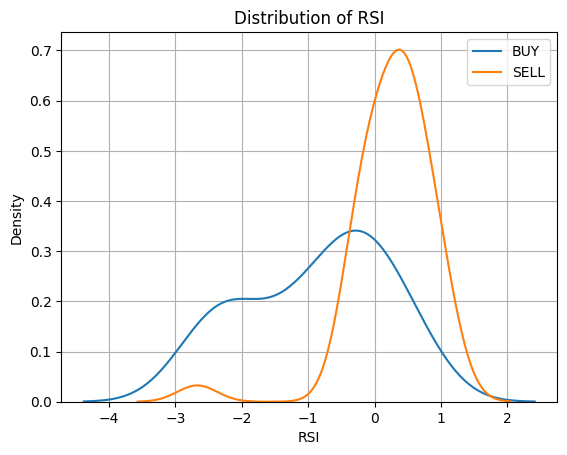

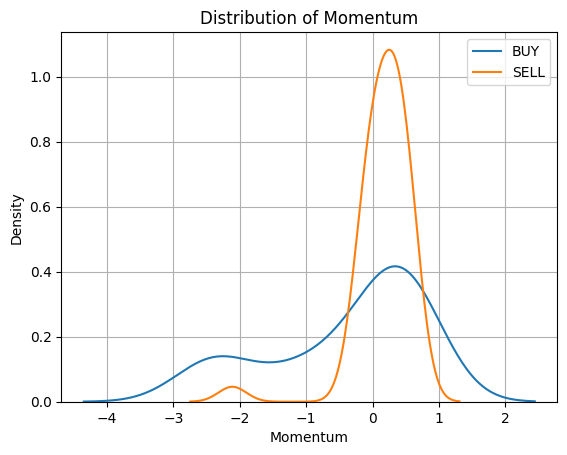

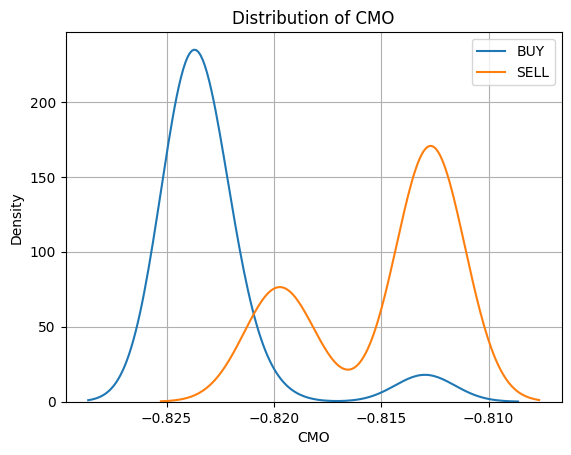

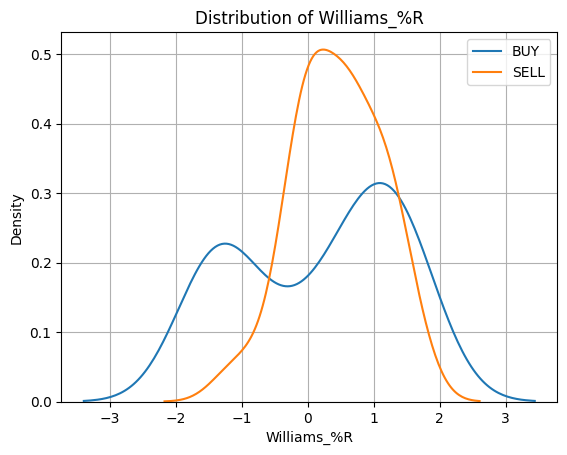

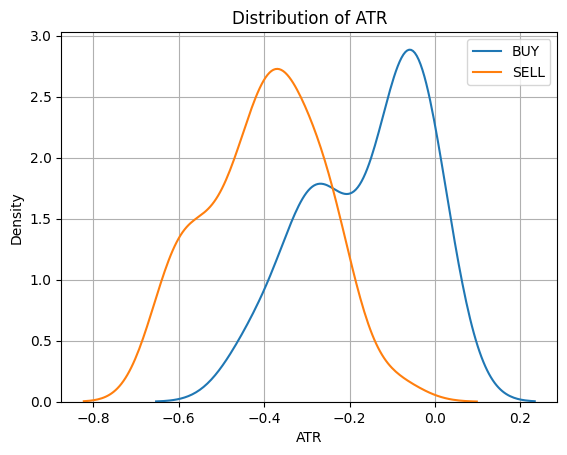

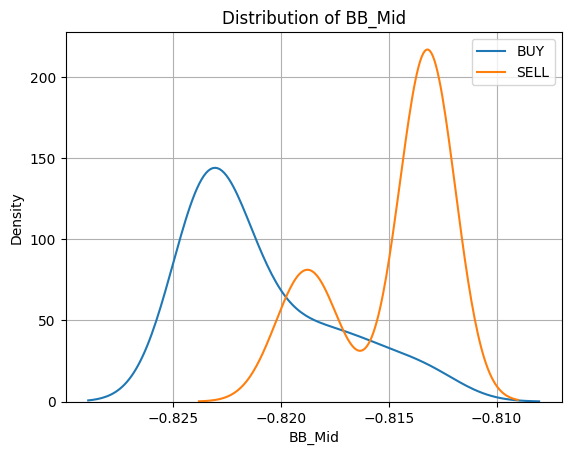

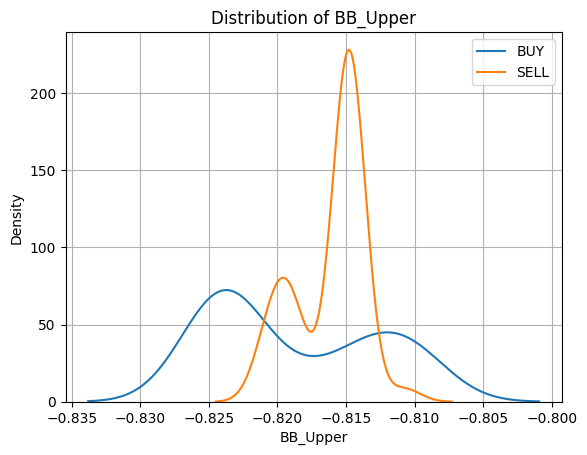

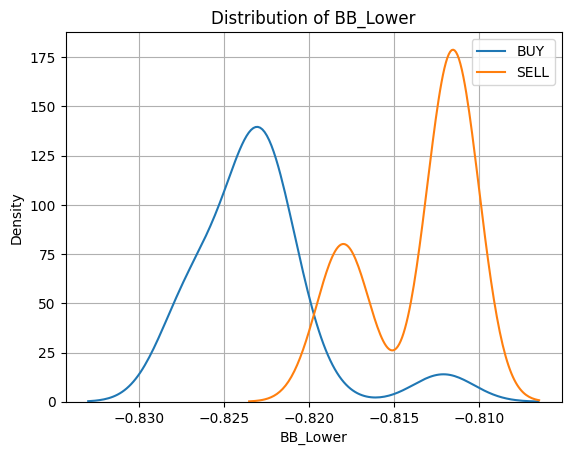

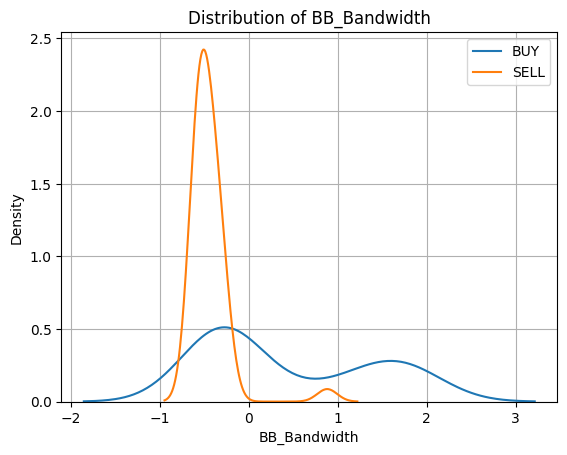

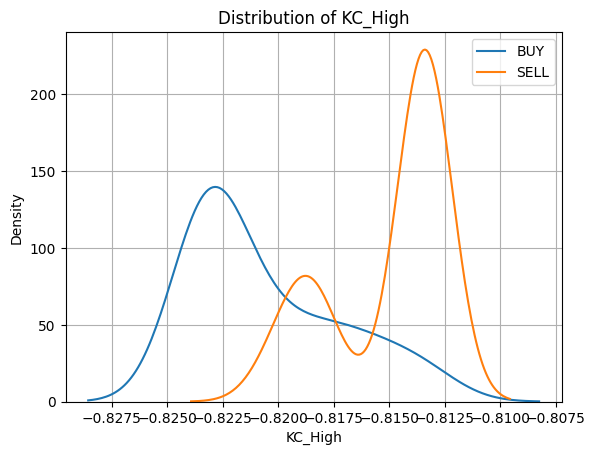

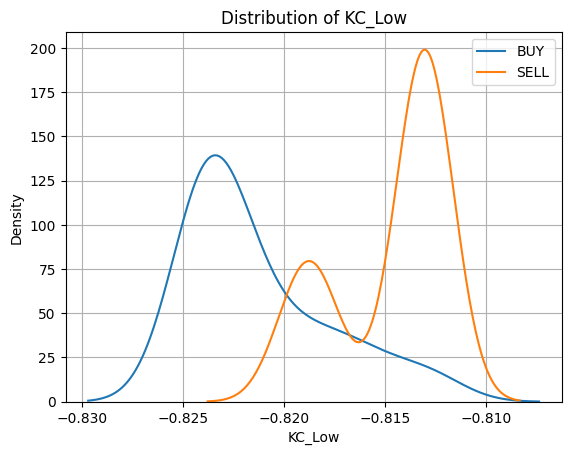

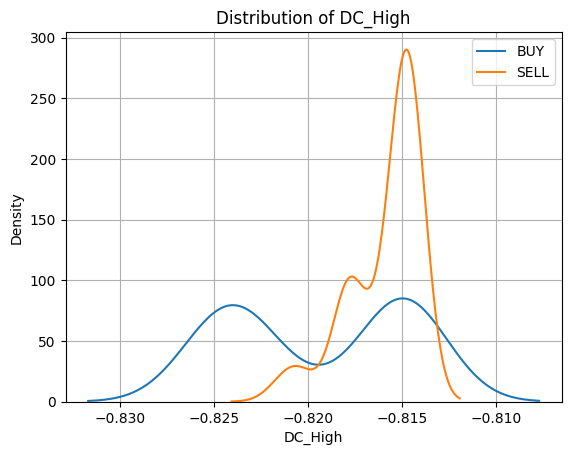

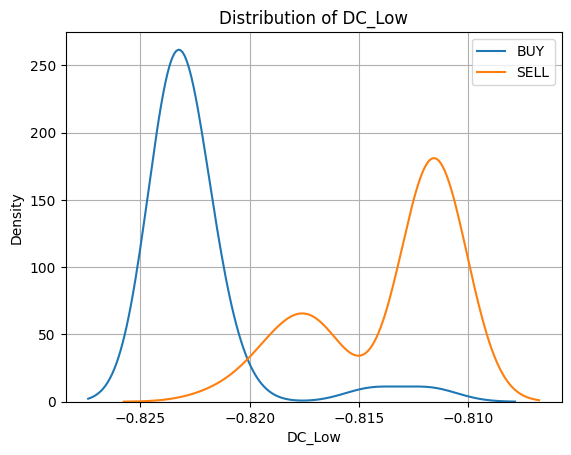

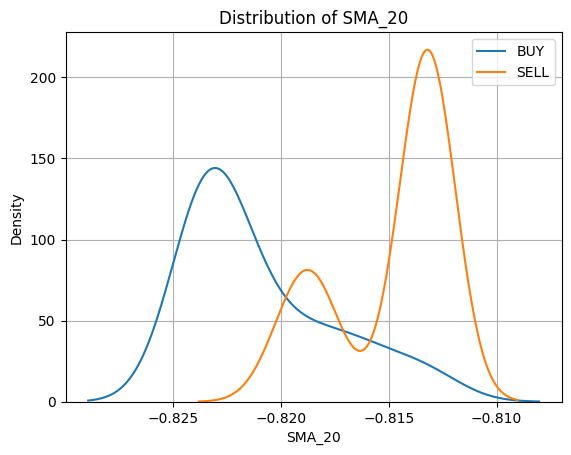

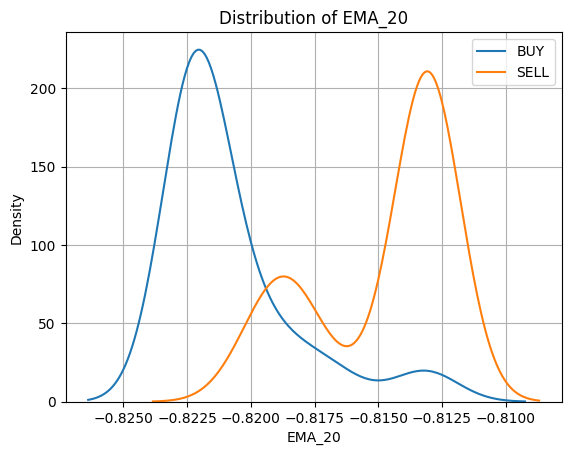

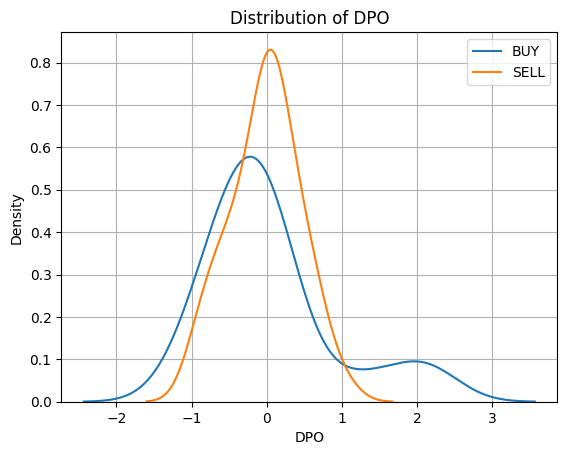

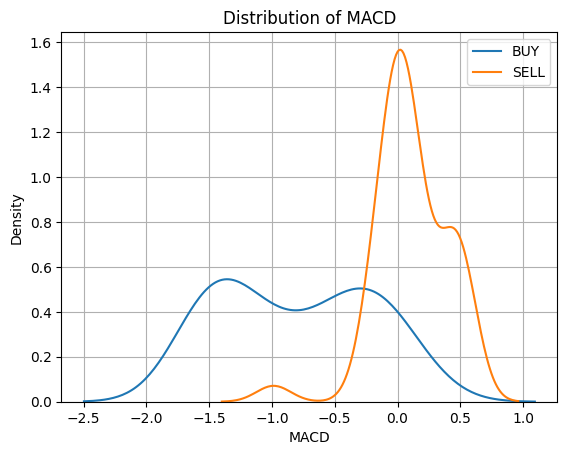

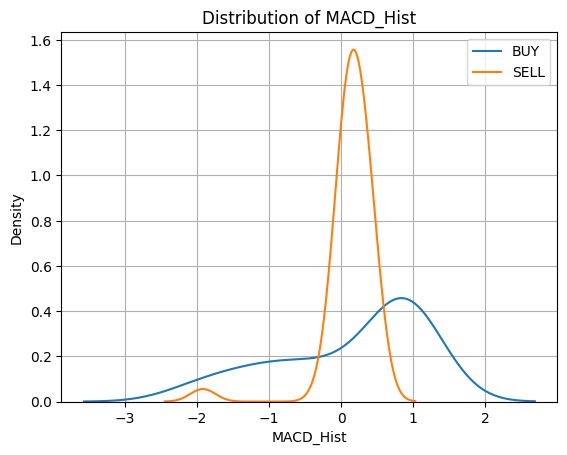

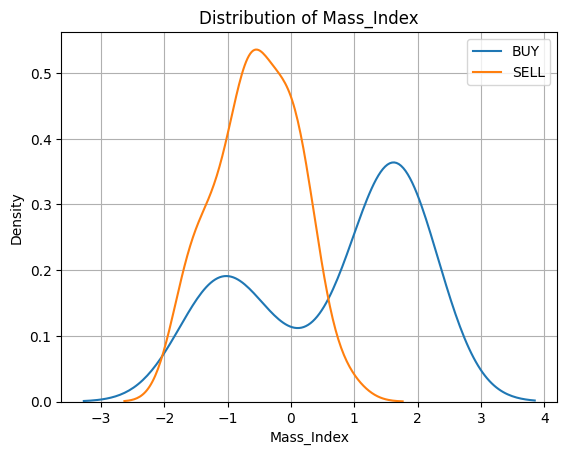

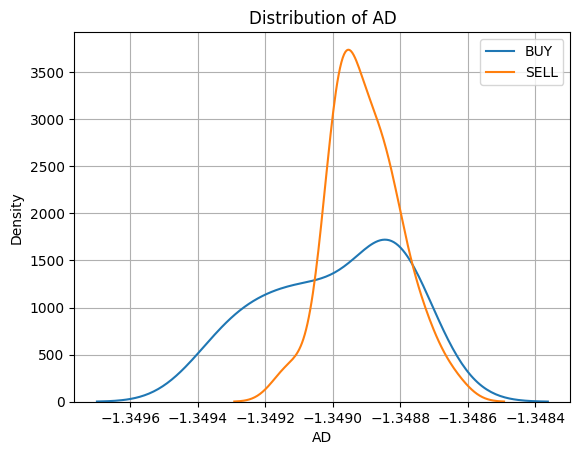

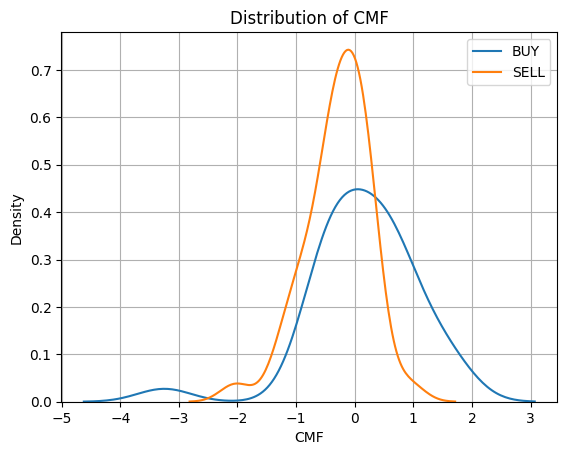

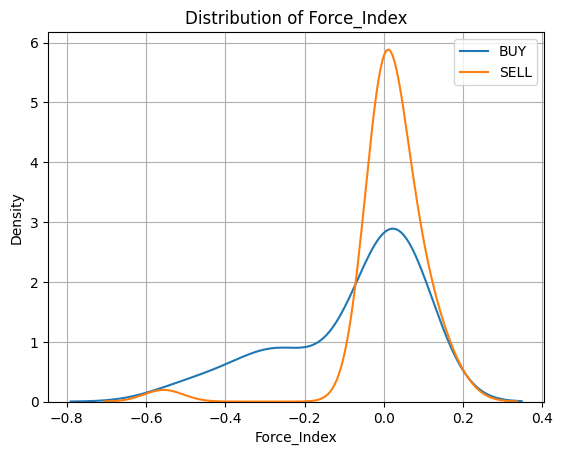

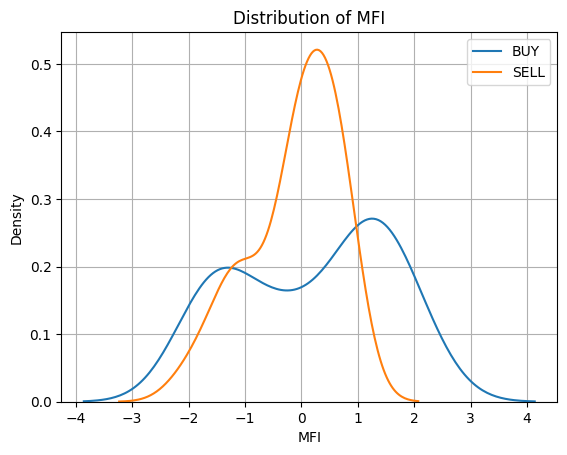

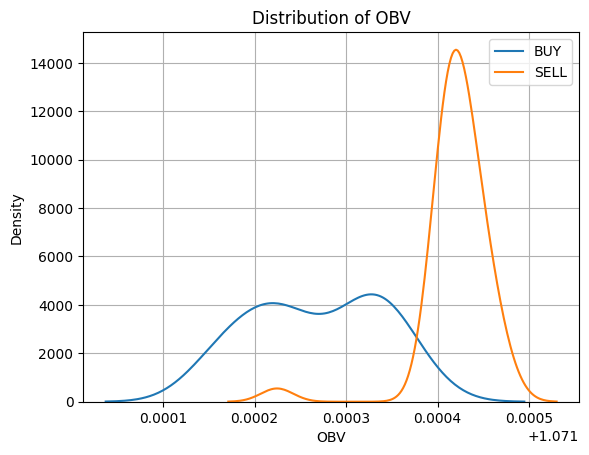

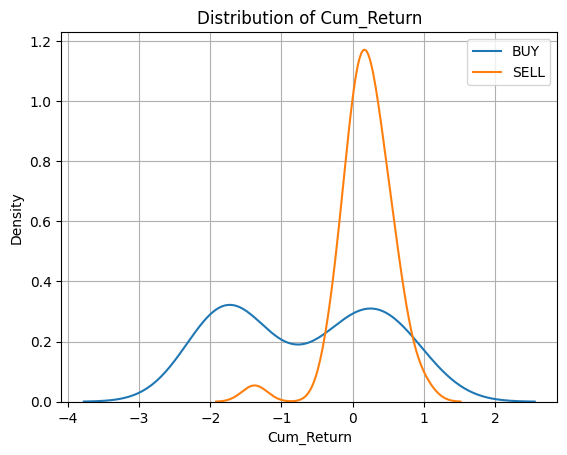

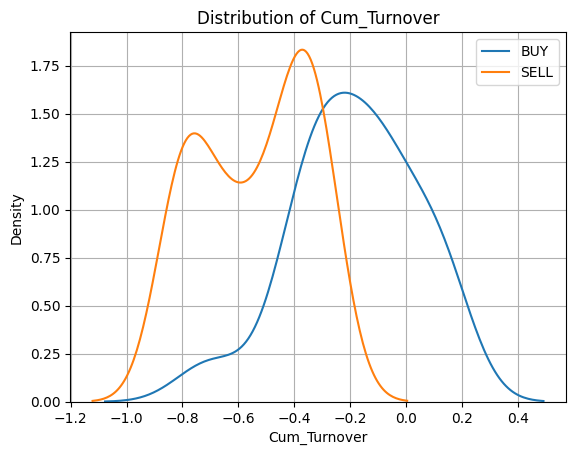

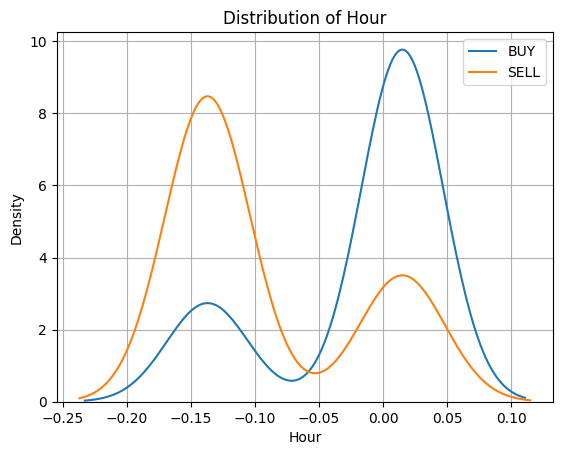

C:\Users\longt\AppData\Local\Temp\ipykernel_3588\1644597433.py:14: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(buy[col], label='BUY')
C:\Users\longt\AppData\Local\Temp\ipykernel_3588\1644597433.py:15: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(sell[col], label='SELL')
C:\Users\longt\AppData\Local\Temp\ipykernel_3588\1644597433.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


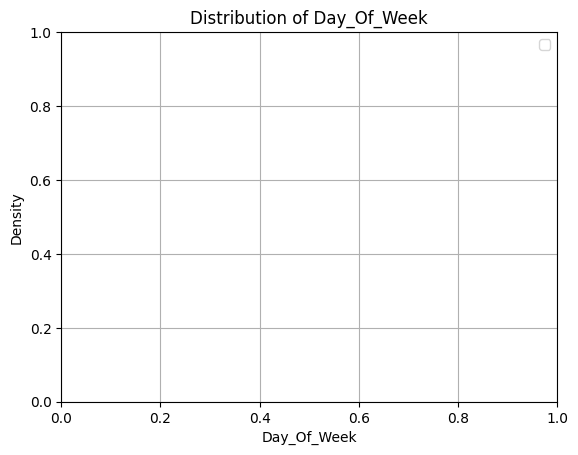

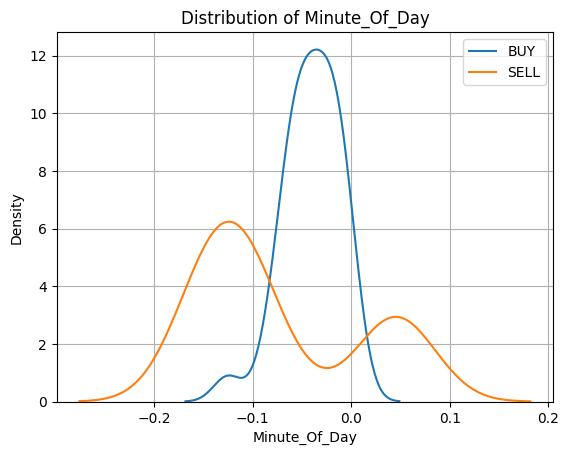

In [13]:
start_dt = '2018-11-20 10:00:00'
end_dt = '2018-11-20 12:00:00'

visualize_kde(train_df, start_dt, end_dt)

In [14]:
from sklearn.feature_selection import mutual_info_classif

def compute_mi(df, start_dt=None, end_dt=None):
    df = df.copy()
    if start_dt and end_dt:
        start_dt = pd.to_datetime(start_dt)
        end_dt = pd.to_datetime(end_dt)
        df = df[(df['Datetime'] >= start_dt) & (df['Datetime'] <= end_dt)]
    
    df_binary = df[df['Label'].isin(['BUY', 'SELL'])]
    X = df_binary.drop(columns=['Label', 'Datetime'])
    y = df_binary['Label']

    mi = mutual_info_classif(X, y, discrete_features=False)
    mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)
    print(mi_series)
    
compute_mi(train_df)

DC_High          0.114445
DC_Low           0.107369
OBV              0.093111
Day_Of_Week      0.036614
CMO              0.032412
AD               0.032392
Close            0.023502
RSI              0.019035
BB_Upper         0.016462
BB_Lower         0.015510
Low              0.015037
ATR              0.013290
Momentum         0.012004
BB_Bandwidth     0.011799
EMA_20           0.011500
Hour             0.011322
Cum_Return       0.011030
Force_Index      0.010747
Williams_%R      0.010582
KC_Low           0.010580
BB_Mid           0.010469
SMA_20           0.010309
KC_High          0.010147
MACD             0.008935
MACD_Hist        0.007499
Open             0.007382
High             0.007124
DPO              0.005887
Volume           0.004809
Minute_Of_Day    0.004252
Cum_Turnover     0.003887
CMF              0.002302
MFI              0.001894
Mass_Index       0.000416
dtype: float64


In [15]:
start_dt = '2018-11-20 10:00:00'
end_dt = '2018-11-20 12:00:00'

compute_mi(train_df, start_dt, end_dt)

OBV              0.600952
Minute_Of_Day    0.591383
BB_Lower         0.580781
CMO              0.580303
DC_Low           0.542765
MACD_Hist        0.460335
EMA_20           0.416993
BB_Upper         0.404407
SMA_20           0.392027
BB_Mid           0.392027
MACD             0.391422
KC_Low           0.388235
DC_High          0.378620
BB_Bandwidth     0.361858
KC_High          0.361184
Mass_Index       0.348058
Cum_Turnover     0.325421
Force_Index      0.308848
RSI              0.300220
ATR              0.287218
MFI              0.202827
Volume           0.189628
Williams_%R      0.187552
Momentum         0.181601
Cum_Return       0.167412
CMF              0.150872
Hour             0.129368
AD               0.116651
DPO              0.080123
Low              0.058124
Day_Of_Week      0.040565
Close            0.022529
Open             0.021518
High             0.016445
dtype: float64


In [16]:
def corr_with_bin(df, start_dt=None, end_dt=None):
    df = df.copy()
    if start_dt and end_dt:
        start_dt = pd.to_datetime(start_dt)
        end_dt = pd.to_datetime(end_dt)
        df = df[(df['Datetime'] >= start_dt) & (df['Datetime'] <= end_dt)]
    
    df_binary = df[df['Label'].isin(['BUY', 'SELL'])]
    X = df_binary.drop(columns=['Label', 'Datetime'])
    y = df_binary['Label']
    
    df_binary['Label_num'] = df_binary['Label'].map({'BUY': 1, 'SELL': 0})
    correlations = df_binary.drop(columns=['Label', 'Datetime']).corrwith(df_binary['Label_num'])
    print(correlations.abs().sort_values(ascending=False))
    
corr_with_bin(train_df)

C:\Users\longt\AppData\Local\Temp\ipykernel_3588\3228566864.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_binary['Label_num'] = df_binary['Label'].map({'BUY': 1, 'SELL': 0})


Label_num        1.000000
ATR              0.148302
BB_Bandwidth     0.120963
RSI              0.081377
Volume           0.078844
Cum_Turnover     0.077189
Close            0.074854
Williams_%R      0.063079
Momentum         0.062333
Low              0.061888
Cum_Return       0.061382
MACD             0.056266
MFI              0.049145
BB_Upper         0.047591
DC_High          0.047564
KC_High          0.047214
BB_Mid           0.046986
SMA_20           0.046986
EMA_20           0.046957
CMO              0.046882
KC_Low           0.046772
BB_Lower         0.046377
DC_Low           0.046292
High             0.040213
CMF              0.038877
MACD_Hist        0.037577
Hour             0.036550
Minute_Of_Day    0.036407
Force_Index      0.027344
Mass_Index       0.024855
DPO              0.021299
Day_Of_Week      0.019804
Open             0.018746
AD               0.017129
OBV              0.003706
dtype: float64


In [17]:
start_dt = '2018-11-20 10:00:00'
end_dt = '2018-11-20 12:00:00'

corr_with_bin(train_df, start_dt, end_dt)

Label_num        1.000000e+00
DC_Low           8.390970e-01
BB_Lower         8.245044e-01
OBV              8.128328e-01
CMO              7.930667e-01
EMA_20           7.575948e-01
KC_Low           7.327115e-01
SMA_20           7.207562e-01
BB_Mid           7.207562e-01
MACD             7.180046e-01
KC_High          6.946755e-01
ATR              6.661389e-01
Cum_Turnover     6.533736e-01
BB_Bandwidth     5.724423e-01
RSI              5.606712e-01
Mass_Index       5.351467e-01
Cum_Return       4.996049e-01
Volume           4.907675e-01
Hour             4.848853e-01
DC_High          4.679814e-01
Force_Index      3.337349e-01
Momentum         3.171058e-01
BB_Upper         3.016777e-01
CMF              2.906522e-01
AD               2.903233e-01
Minute_Of_Day    2.617983e-01
Williams_%R      1.582977e-01
Low              1.507961e-01
MFI              1.492273e-01
Close            1.118887e-01
High             1.086434e-01
Open             7.613220e-02
DPO              3.973135e-02
MACD_Hist 

C:\Users\longt\AppData\Local\Temp\ipykernel_3588\3228566864.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_binary['Label_num'] = df_binary['Label'].map({'BUY': 1, 'SELL': 0})
